### Prediction model for DAENERGY

In the following notebook are considered two different approach to predict the price of DAENERGY

In [102]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from src.process_data import pivot_data, create_index, clean_data

#### Loading and cleaning data

- Pivot table
- It's considered data from 2017-07-05 to 2017-10-30
- There are some missing values. Those values where computed using replicating the value of the previous observation (To obtain an index with hourly frequency and obtain forecasts using stats models.
- It's created the index with TRADEDATE and HOUROFWEEK. Finally we obtain the exact date and time of trade.


In [103]:
df = pivot_data('data/Data.txt')
df = clean_data(df)
df = create_index(df)

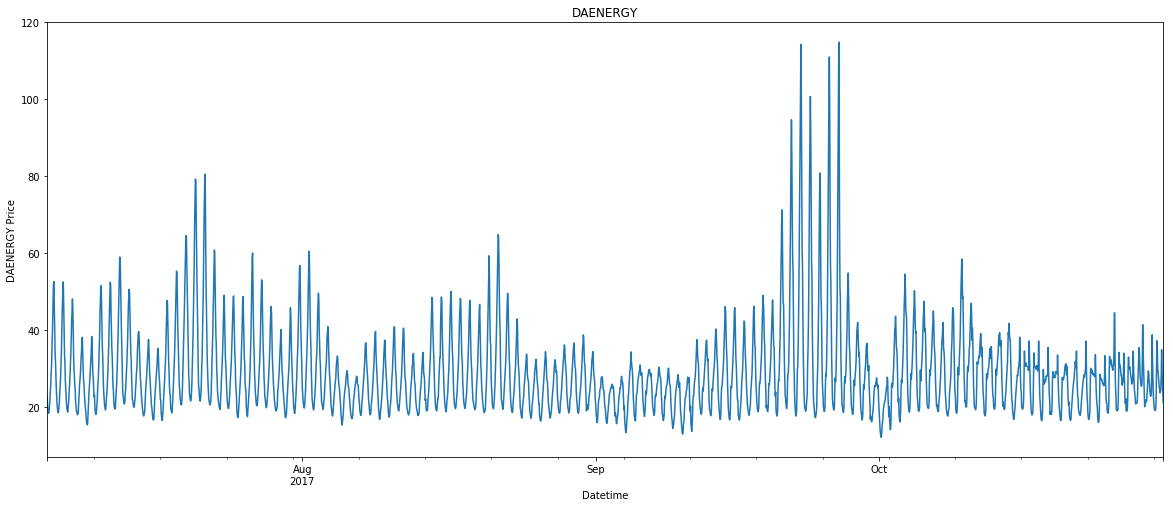

In [3]:
plt.figure(figsize=(20,8))
df.DAENERGY.plot()
plt.title('DAENERGY')
plt.xlabel('Datetime')
plt.ylabel('DAENERGY Price');

In [4]:
df.head()

REGION,TRADEDATE,HOUROFWEEK,CYWG,K2G4,KABE,KABI,KACT,KACY,KADS,KAKR,...,KVCT,KWRI,KYNG,KZZV,LOAD,DAENERGY,RTENERGY,ISOWIND,OUTAGE,hourofday
dt,,,,,,,,,,,,,,,,,,,,,
2017-07-05 01:00:00,2017-07-05,73,67,63,66,77,83,70,80,69,...,81,67,68,70,78515,22.89,22.06,4576.170,14310,01:00:00
2017-07-05 02:00:00,2017-07-05,74,63,62,67,81,84,69,84,63,...,80,68,61,66,68721,20.17,19.97,2952.209,13300,02:00:00
2017-07-05 03:00:00,2017-07-05,75,62,62,66,80,82,69,82,62,...,79,68,61,65,65820,19.42,19.41,2791.408,13300,03:00:00
2017-07-05 04:00:00,2017-07-05,76,61,62,66,78,80,69,80,61,...,78,67,60,64,64262,18.74,19.09,2525.984,13300,04:00:00
2017-07-05 05:00:00,2017-07-05,77,59,61,66,75,79,68,80,60,...,77,67,59,64,64020,18.49,18.64,2520.608,13300,05:00:00


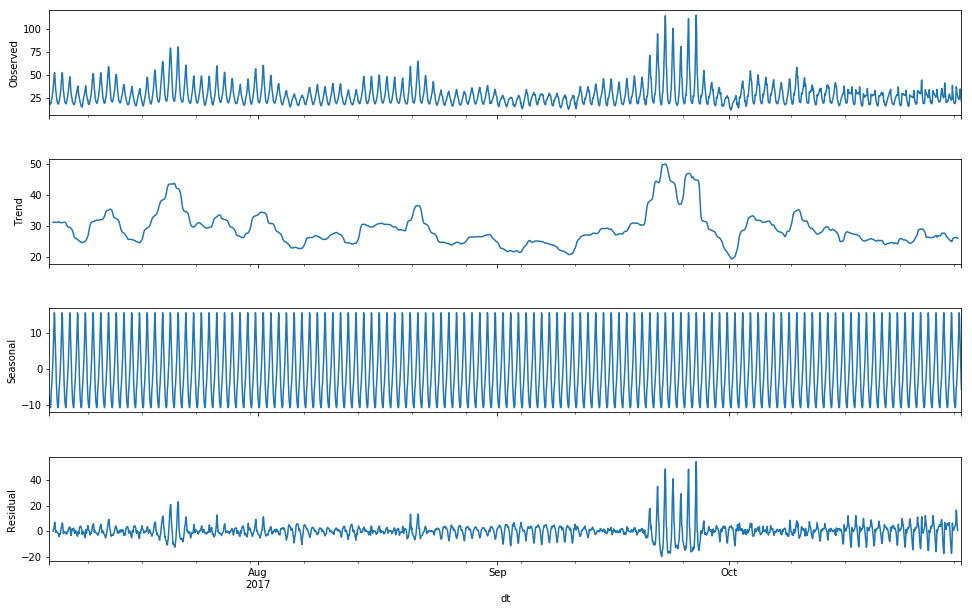

In [5]:
decomposition = seasonal_decompose(df.DAENERGY, freq = 24)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 10)

In [6]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=24)
    #rolstd = pd.rolling_std(timeseries, window=24)
    rolmean = pd.Series.rolling(timeseries, window=24, center=False).mean()
    rolstd = pd.Series.rolling(timeseries, window=24, center=False).std()
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

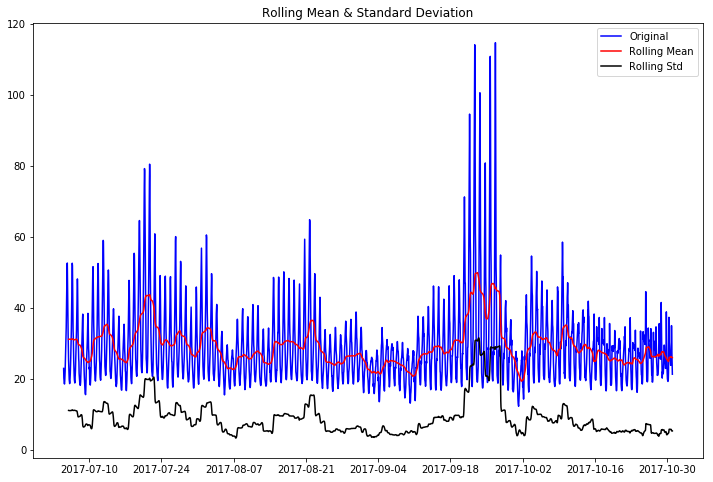

Results of Dickey-Fuller Test:
Test Statistic                   -3.517626
p-value                           0.007546
#Lags Used                       26.000000
Number of Observations Used    2805.000000
Critical Value (1%)              -3.432683
Critical Value (5%)              -2.862571
Critical Value (10%)             -2.567319
dtype: float64


In [7]:
test_stationarity(df.DAENERGY)

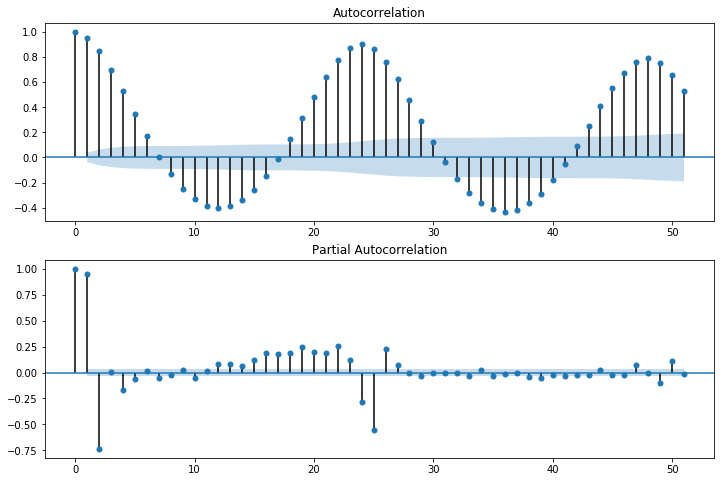

In [92]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.DAENERGY.iloc[50:], lags=51, ax=ax1, alpha = 0.05)#25,26
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.DAENERGY.iloc[50:], lags=51, ax=ax2,alpha = 0.05)

### SARIMAX MODEL

In [9]:
def create_model(dd, date_predict, exogens):
    mod = sm.tsa.statespace.SARIMAX(dd.DAENERGY,exogen = dd[exogens], trend='n', order=(0,1,0), seasonal_order=(1,1,1,24))
    results = mod.fit()
    print (results.summary())
    pred = results.forecast(24)
    real = df[date_predict].DAENERGY
    RMSE=get_rmse(pred,real)
    plt.plot(df[date_predict].index, real,'g',pred.index,pred,'r' )
    plt.title('RMSE = {:.2f}'.format(RMSE))
    plt.xlabel('time')
    plt.ylabel('Price DAENERGY')
    return results, mod

def get_rmse(pred, real):
    return np.sqrt(((pred-real)**2).sum()/(pred.shape[0]))

In [10]:
temps = []
for col in df.columns.values:
    if len(col)==4:
        temps.append(col)
        
def check_bad_data(df):
    temp = df.groupby('TRADEDATE').count()['HOUROFWEEK']
    temp[temp<24]
    df[df['TRADEDATE'] == '2017-10-25']
    

#### Training the Model
Using historical data until one day before of the day to predict

                                 Statespace Model Results                                 
Dep. Variable:                           DAENERGY   No. Observations:                 1007
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 24)   Log Likelihood               -1510.881
Date:                            Mon, 20 Nov 2017   AIC                           3027.762
Time:                                    19:29:57   BIC                           3042.506
Sample:                                07-05-2017   HQIC                          3033.364
                                     - 08-15-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.6275      0.023     27.832      0.000       0.583       0.672
ma.S.L24      -0.9990      0.810   

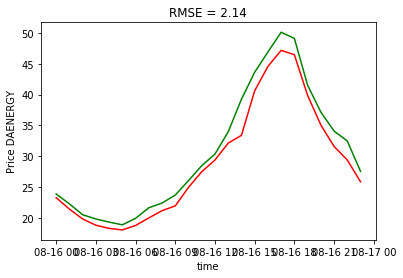

In [11]:
res, mod = create_model(df[:'2017-08-15'],'2017-08-16',temps)

In [12]:
fcast = res.get_forecast(24)
fcast_ci= fcast.conf_int(alpha=0.25)
print(fcast.predicted_mean)
print('')
print('75% of Confidence Interval')
print(fcast_ci)

2017-08-16 00:00:00    23.263397
2017-08-16 01:00:00    21.414675
2017-08-16 02:00:00    19.806091
2017-08-16 03:00:00    18.798893
2017-08-16 04:00:00    18.276033
2017-08-16 05:00:00    18.032493
2017-08-16 06:00:00    18.754600
2017-08-16 07:00:00    19.979790
2017-08-16 08:00:00    21.159397
2017-08-16 09:00:00    21.933292
2017-08-16 10:00:00    24.940790
2017-08-16 11:00:00    27.478009
2017-08-16 12:00:00    29.384096
2017-08-16 13:00:00    32.126541
2017-08-16 14:00:00    33.387377
2017-08-16 15:00:00    40.625879
2017-08-16 16:00:00    44.579501
2017-08-16 17:00:00    47.187716
2017-08-16 18:00:00    46.482910
2017-08-16 19:00:00    39.878468
2017-08-16 20:00:00    35.076029
2017-08-16 21:00:00    31.586414
2017-08-16 22:00:00    29.384350
2017-08-16 23:00:00    25.848000
Freq: H, dtype: float64

75% of Confidence Interval
                     lower DAENERGY  upper DAENERGY
2017-08-16 00:00:00       21.989179       24.537616
2017-08-16 01:00:00       19.612658       23.216693


In [13]:
predict = fcast
predict_ci = fcast_ci

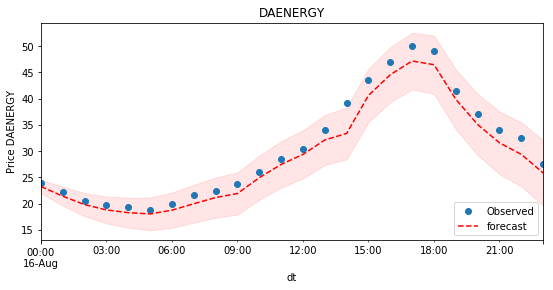

In [14]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 24
ax.set(title='DAENERGY', xlabel='Date', ylabel='Price DAENERGY')

# Plot data points
df.loc['2017-08-16', 'DAENERGY'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2017-08-16'].plot(ax=ax, style='r--', label='forecast')
ci = predict_ci.loc['2017-08-16']
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
legend = ax.legend(loc='lower right')

### AdaBoost Regressor

In [15]:
from sklearn.ensemble import AdaBoostRegressor

#### Cleaning Data for SKLEARN AdaBoost Model

The model will be trained with the historical data until one day before of the prediction required:

In [16]:
sk_df = df[:'2017-08-15'].copy()
sk = sk_df.drop(['TRADEDATE', 'RTENERGY'], axis=1)
sk.hourofday = sk.hourofday.dt.seconds/3600
sk['daybefore'] = sk.DAENERGY.shift(24)
sk = sk.dropna()
y = sk.pop('DAENERGY').values
X = sk.values

#### Creating Model and Training

In [17]:
model = AdaBoostRegressor()
model = model.fit(X,y)

#### Preparing data of 2017-08-16 to make prediction

In [18]:
input_p = df['2017-08-15':'2017-08-16'].copy()
input_p['daybefore'] = input_p.DAENERGY.shift(24)
input_p = input_p.drop(['DAENERGY','TRADEDATE', 'RTENERGY'], axis=1)
input_p.hourofday = input_p.hourofday.dt.seconds/3600
input_p = input_p.dropna()

#### Predictions for 2017-08-16

In [19]:
results = df['2017-08-16'].copy()
pred_ada = model.predict(input_p.values)
results['forecast'] = pred_ada

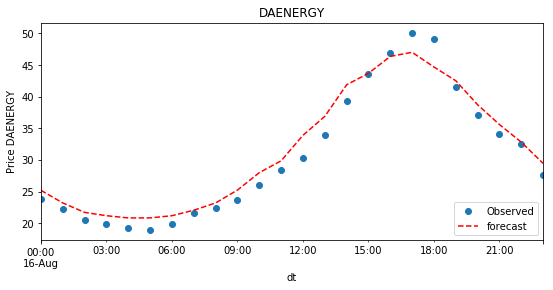

In [20]:
fig, ax = plt.subplots(figsize=(9,4))
npre = 24
ax.set(title='DAENERGY', xlabel='Date', ylabel='Price DAENERGY')

# Plot data points
results.loc['2017-08-16', 'DAENERGY'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
results.forecast.plot(ax=ax, style='r--', label='forecast')
ci = predict_ci.loc['2017-08-16']
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
legend = ax.legend(loc='lower right')

In [21]:
RMSE = get_rmse(df['2017-08-16']['DAENERGY'], pred_ada)
print('RMSE for AdaBoost Model: ', RMSE)

RMSE for AdaBoost Model:  1.93240691631


#### Top Features Importance:

In [22]:
input_p.columns.values[np.argsort(model.feature_importances_)[::-1]]


array(['LOAD', 'daybefore', 'KDSM', 'KLRD', 'KCMI', 'KMLI', 'KELP', 'KFWA',
       'KGRB', 'KCOU', 'KSAT', 'KTEB', 'hourofday', 'KAMA', 'KSTL',
       'HOUROFWEEK', 'KINK', 'KPHL', 'ISOWIND', 'KEWR', 'KLBB', 'KSGF',
       'KCVG', 'KDTW', 'CYWG', 'KODO', 'KIND', 'KGFK', 'KCGI', 'KAWM',
       'KMCI', 'KCID', 'KCGX', 'KBWI', 'KELD', 'KVCT', 'KATT', 'KROA',
       'KFAR', 'KTOL', 'KPIA', 'KDET', 'KBPT', 'KSMQ', 'KFST', 'KERI',
       'KOXB', 'KSUX', 'KEVV', 'KMGW', 'KCRP', 'KRIC', 'KRFD', 'KRDU',
       'KCKB', 'KCLE', 'KCLL', 'KCMH', 'KRDG', 'KZZV', 'KCRW', 'KSBN',
       'KPRX', 'KDAL', 'KDAY', 'KDBQ', 'KDCA', 'KDEC', 'KPIT', 'KDFW',
       'KCAK', 'KBTR', 'KDMH', 'KANJ', 'KSPS', 'K2G4', 'KABE', 'KABI',
       'KACT', 'KACY', 'KADS', 'KAKR', 'OUTAGE', 'KAOO', 'KBRO', 'KARB',
       'KARR', 'KSPI', 'KAUS', 'KAVP', 'KSJT', 'KBAZ', 'KBIS', 'KSBY',
       'KDLH', 'KDOV', 'KMDW', 'KUES', 'KILG', 'KMLU', 'KTTN', 'KINL',
       'KIPT', 'KJAN', 'KJCT', 'KLAN', 'KMKG', 'KLCH', 'KLFK', 'KLIT',
 

In [105]:
def train_and_predict(df,date_predict):
    #Prepartinf data to Train
    #print('Preparing data to Train')
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    sk_df = df[:date_limit].copy()
    sk = sk_df.drop(['TRADEDATE', 'RTENERGY'], axis=1)
    sk.hourofday = sk.hourofday.dt.seconds/3600
    sk['daybefore'] = sk.DAENERGY.shift(24)
    sk = sk.dropna()
    y = sk.pop('DAENERGY').values
    X = sk.values
    
    #Training Model
    #print('Training Model')
    model = AdaBoostRegressor(random_state=10)
    model = model.fit(X,y)
    
    #preparing data to Predict
    #print('Preparing data to predict')
    input_p = df[date_limit:date_predict].copy()
    input_p['daybefore'] = input_p.DAENERGY.shift(24)
    input_p = input_p.drop(['DAENERGY','TRADEDATE', 'RTENERGY'], axis=1)
    input_p.hourofday = input_p.hourofday.dt.seconds/3600
    input_p = input_p.dropna()
    
    results = df[date_predict].copy()
    pred_ada = model.predict(input_p.values)
    results['forecast'] = pred_ada
    RMSE = get_rmse(df[date_predict]['DAENERGY'], pred_ada)
    print('RMSE for AdaBoost Model: ', RMSE)
    #preparing to plot
    #print('Ploting results')
    fig, ax = plt.subplots(figsize=(9,4))
    npre = 24
    ax.set(title='DAENERGY '+ 'RMSE: {:.3f} for {}'.format(RMSE, date_predict), xlabel='Date', ylabel='Price DAENERGY')

    # Plot data points
    df.loc[date_predict, 'DAENERGY'].plot(ax=ax, style='o', label='Observed')

    # Plot predictions
    results.forecast.plot(ax=ax, style='r--', label='forecast')
    #ci = predict_ci.loc[date_predict]
    #ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
    legend = ax.legend(loc='lower right')
    
    

    return results, RMSE

def create_date_range(start_date, end_date):
    start_dt = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
    end_dt = datetime.datetime.strptime(end_date, "%Y-%m-%d").date()
    dates = []
    cur_dt = start_dt
    dates.append(start_date)
    while cur_dt<end_dt:
        cur_dt = cur_dt + datetime.timedelta(days=1)
        dates.append(cur_dt.strftime('%Y-%m-%d'))
    return dates

RMSE for AdaBoost Model:  4.04358185934


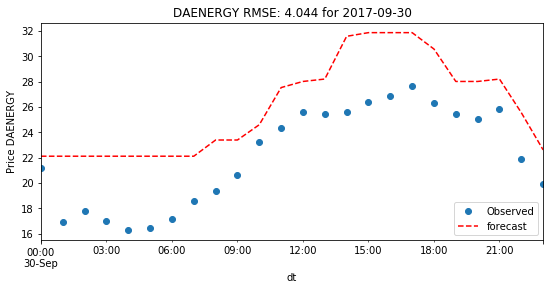

In [106]:
res, rmse = train_and_predict(df,'2017-09-30')

Working for date 2017-08-01
RMSE for AdaBoost Model:  3.43976820954
Working for date 2017-08-02
RMSE for AdaBoost Model:  1.62177473737
Working for date 2017-08-03
RMSE for AdaBoost Model:  1.65376843737
Working for date 2017-08-04
RMSE for AdaBoost Model:  1.20412306342
Working for date 2017-08-05
RMSE for AdaBoost Model:  2.28809949715
Working for date 2017-08-06
RMSE for AdaBoost Model:  1.47901443188
Working for date 2017-08-07
RMSE for AdaBoost Model:  2.58674500865
Working for date 2017-08-08
RMSE for AdaBoost Model:  1.44758574518
Working for date 2017-08-09
RMSE for AdaBoost Model:  2.06257327443
Working for date 2017-08-10
RMSE for AdaBoost Model:  1.64689094548
Working for date 2017-08-11
RMSE for AdaBoost Model:  1.59493766841
Working for date 2017-08-12
RMSE for AdaBoost Model:  1.21842959427
Working for date 2017-08-13
RMSE for AdaBoost Model:  1.56796250374
Working for date 2017-08-14
RMSE for AdaBoost Model:  4.23877661542
Working for date 2017-08-15
RMSE for AdaBoost Mo

/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  2.2171363956
Working for date 2017-08-23


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.06854598305
Working for date 2017-08-24


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.8169924062
Working for date 2017-08-25


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.43727288445
Working for date 2017-08-26


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  2.99539255161
Working for date 2017-08-27


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  2.08683967647
Working for date 2017-08-28


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  2.37574473032
Working for date 2017-08-29


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.6103682544
Working for date 2017-08-30


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.74564849783
Working for date 2017-08-31


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  1.25640366475


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


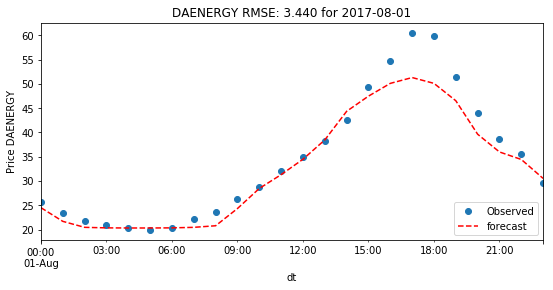

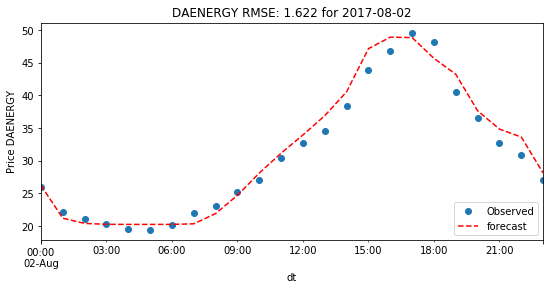

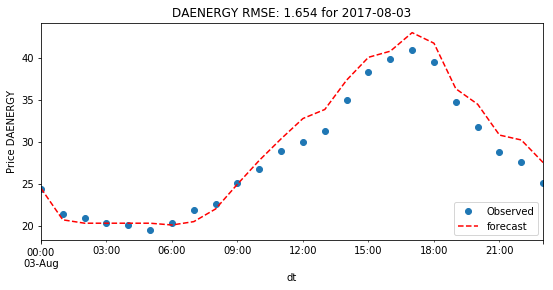

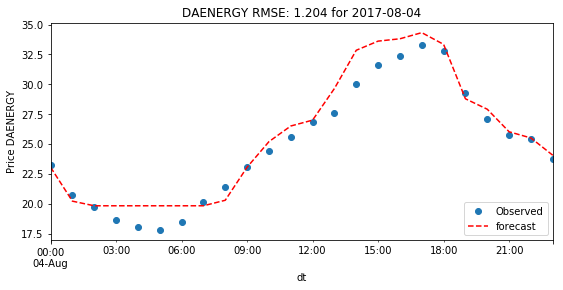

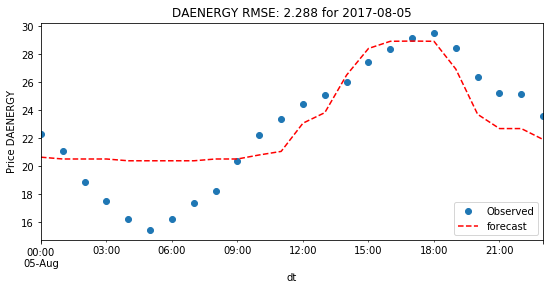

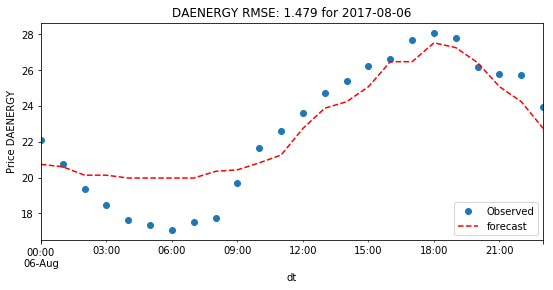

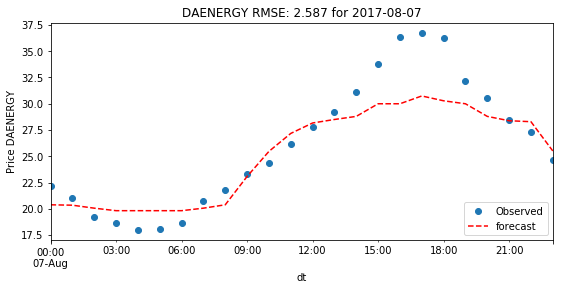

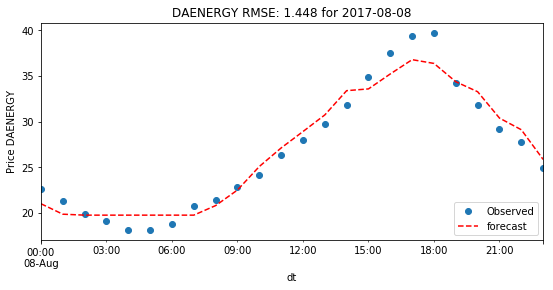

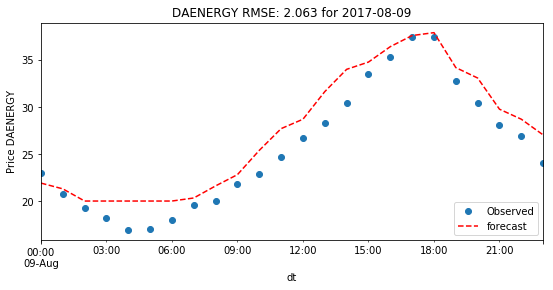

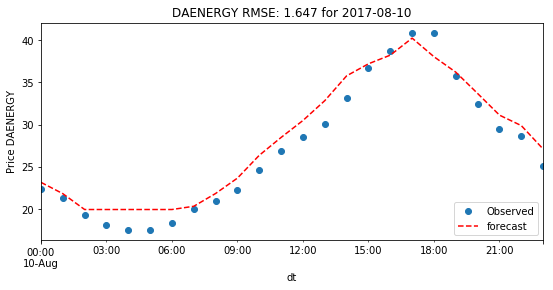

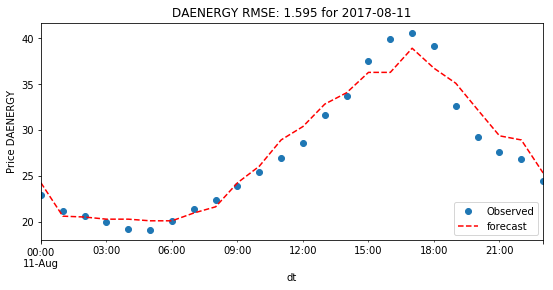

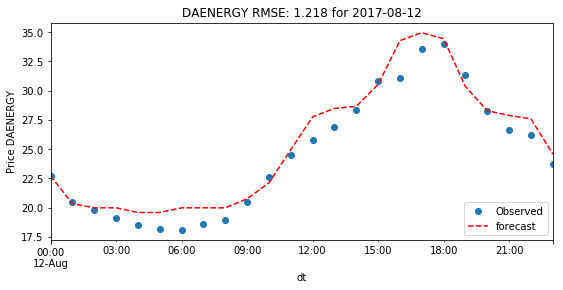

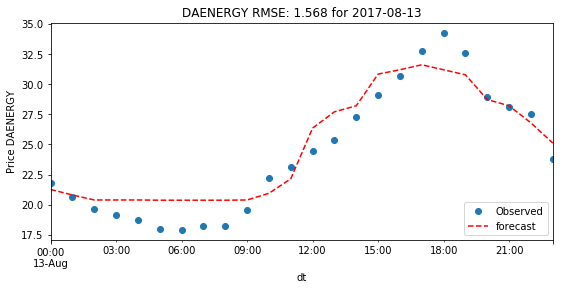

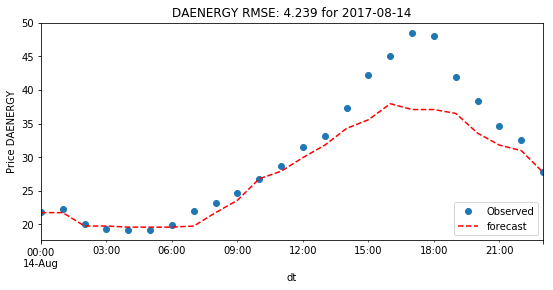

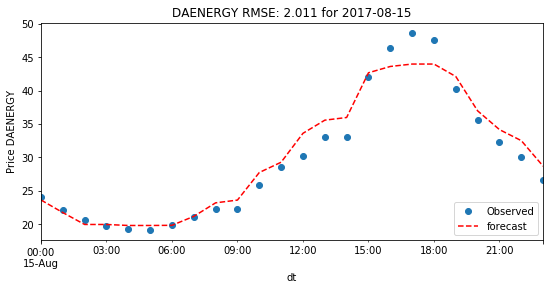

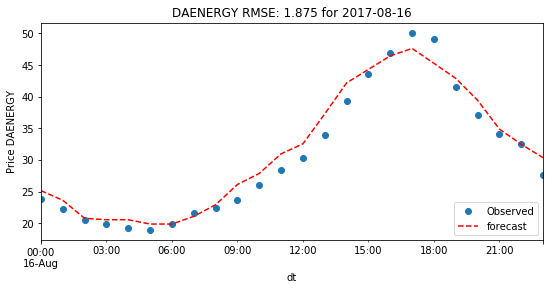

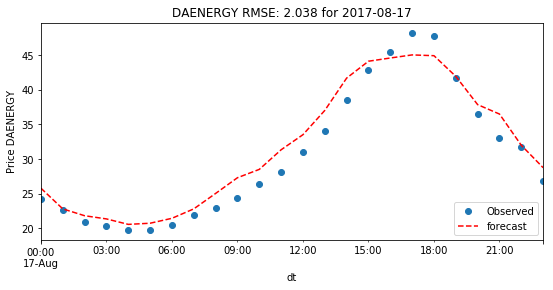

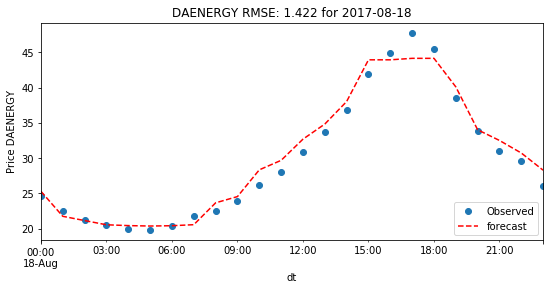

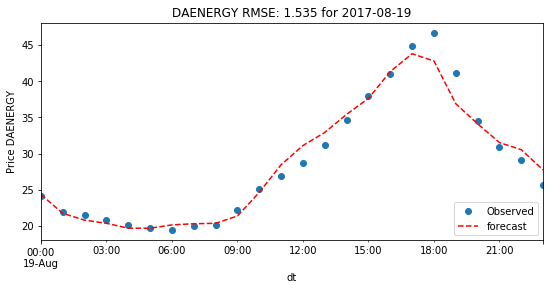

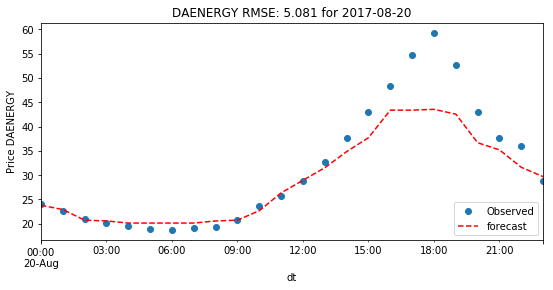

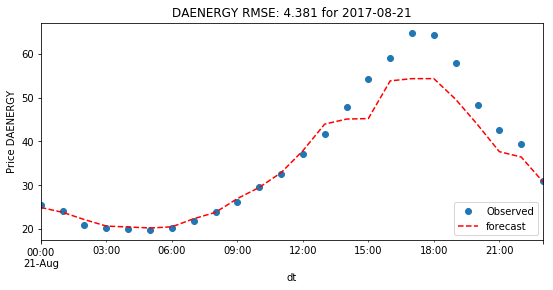

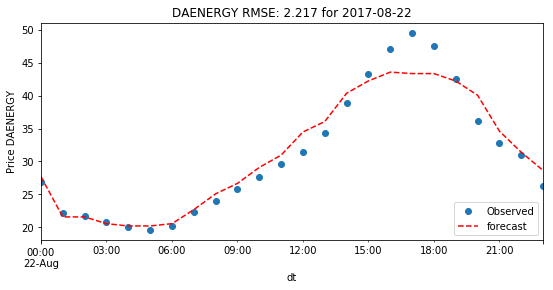

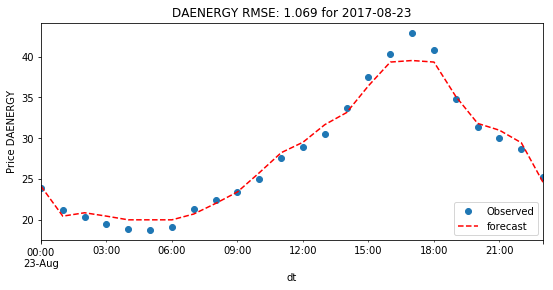

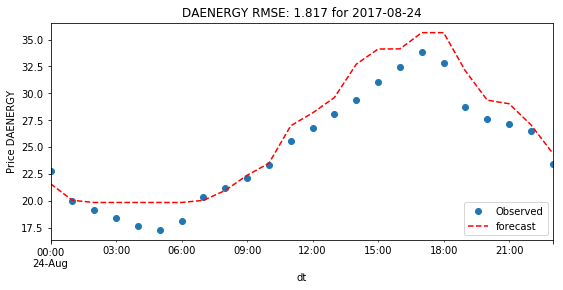

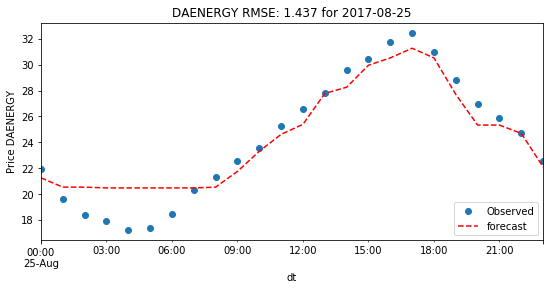

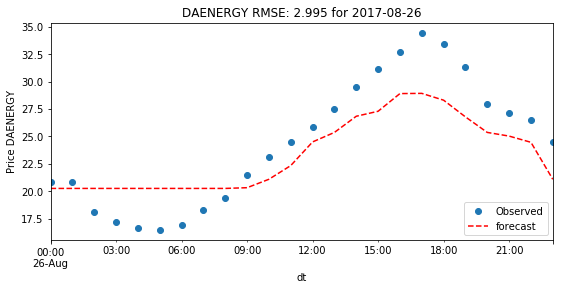

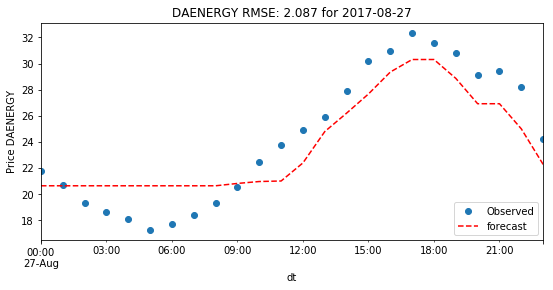

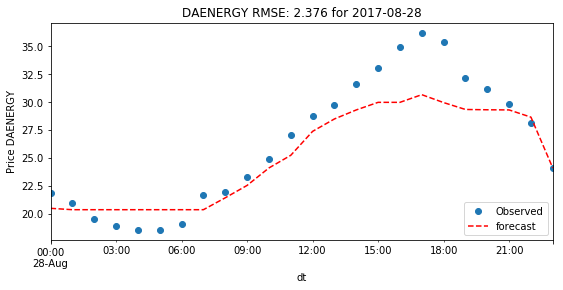

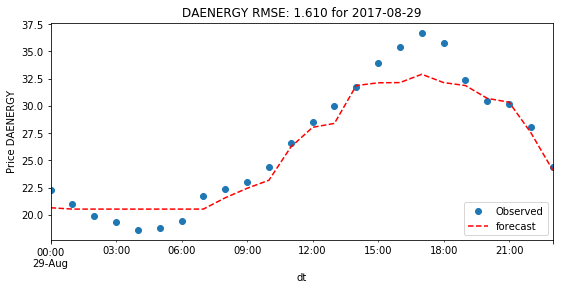

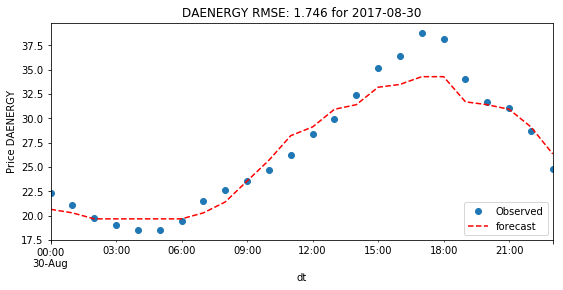

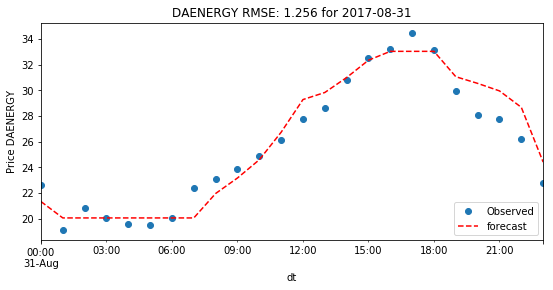

In [60]:
rmses = []
for dt in create_date_range('2017-08-01', '2017-08-31'):
    print('Working for date {}'.format(dt))
    res, rmse = train_and_predict(df,dt)
    rmses.append(rmse)

Mean RMSE for september: 2.0969116482115195


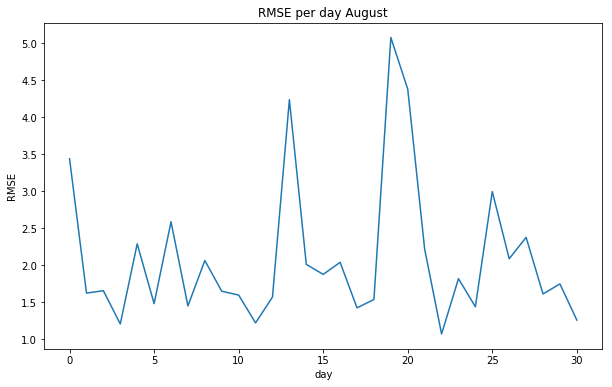

In [61]:
plt.figure(figsize = (10,6))
plt.plot(rmses)
plt.title('RMSE per day August')
plt.xlabel('day')
plt.ylabel('RMSE')
mean_august = np.array(rmses).mean()
print('Mean RMSE for september: {}'.format(mean_august))

Working for date 2017-09-01
RMSE for AdaBoost Model:  2.62906798024
Working for date 2017-09-02
RMSE for AdaBoost Model:  2.12656500461
Working for date 2017-09-03
RMSE for AdaBoost Model:  2.05149779455
Working for date 2017-09-04
RMSE for AdaBoost Model:  2.99206436714
Working for date 2017-09-05
RMSE for AdaBoost Model:  1.82715503991
Working for date 2017-09-06
RMSE for AdaBoost Model:  1.74592074214
Working for date 2017-09-07
RMSE for AdaBoost Model:  1.34324188507
Working for date 2017-09-08
RMSE for AdaBoost Model:  1.40719484682
Working for date 2017-09-09
RMSE for AdaBoost Model:  2.20611070649
Working for date 2017-09-10
RMSE for AdaBoost Model:  2.82624035776
Working for date 2017-09-11
RMSE for AdaBoost Model:  4.2703318957
Working for date 2017-09-12
RMSE for AdaBoost Model:  2.06860292481
Working for date 2017-09-13
RMSE for AdaBoost Model:  2.42415931547
Working for date 2017-09-14
RMSE for AdaBoost Model:  3.51307067943
Working for date 2017-09-15
RMSE for AdaBoost Mod

/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  10.9047771862
Working for date 2017-09-23


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  9.44242445909
Working for date 2017-09-24


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  8.75227327607
Working for date 2017-09-25


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  14.8657163562
Working for date 2017-09-26


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  11.5466384675
Working for date 2017-09-27


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  12.2703301352
Working for date 2017-09-28


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  2.59147430739
Working for date 2017-09-29


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  2.36370151633
Working for date 2017-09-30


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for AdaBoost Model:  4.04358185934


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


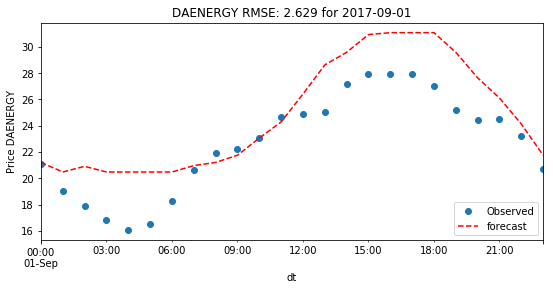

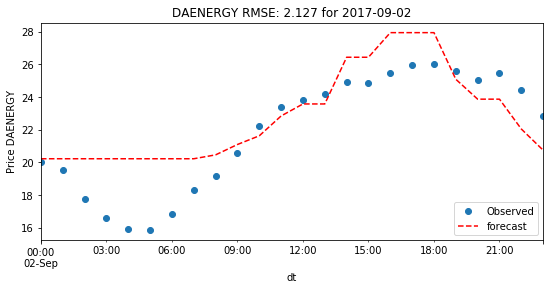

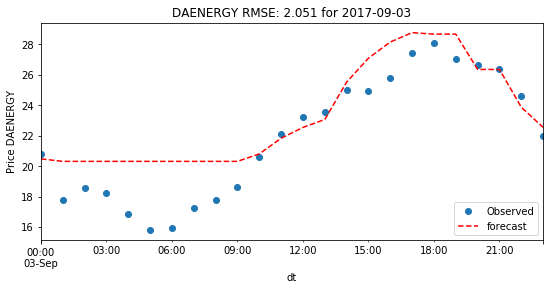

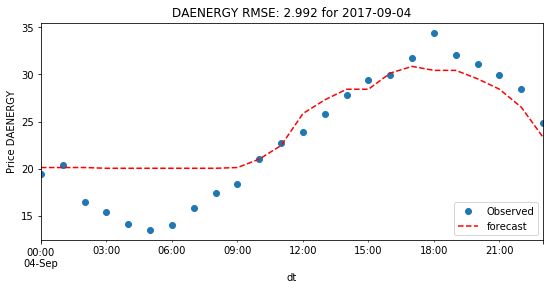

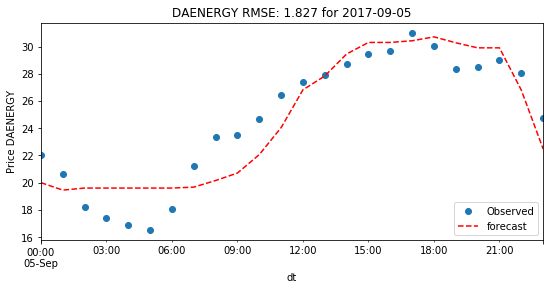

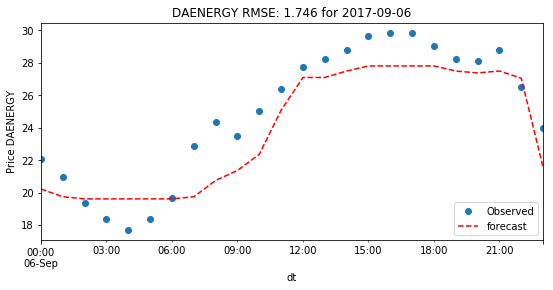

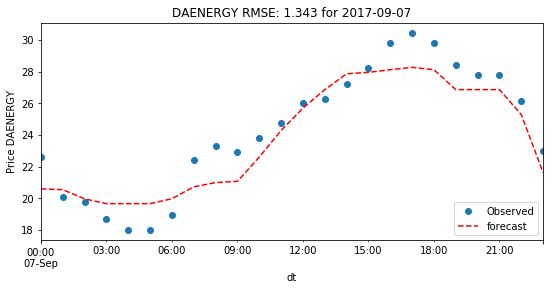

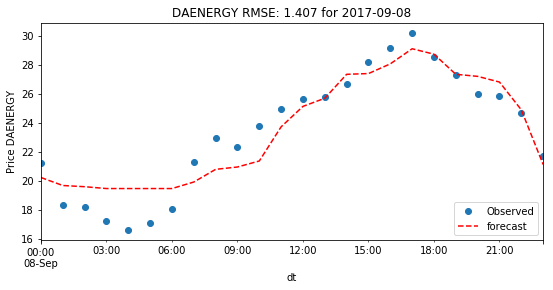

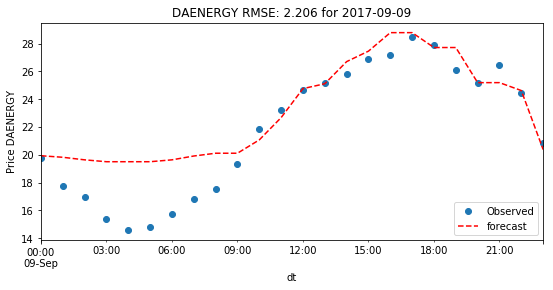

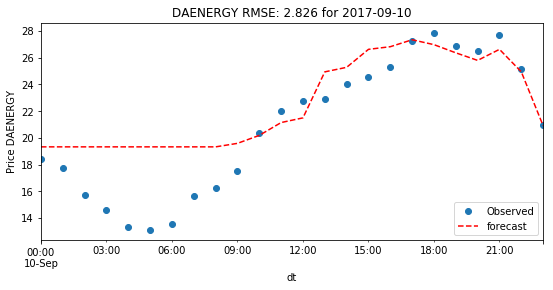

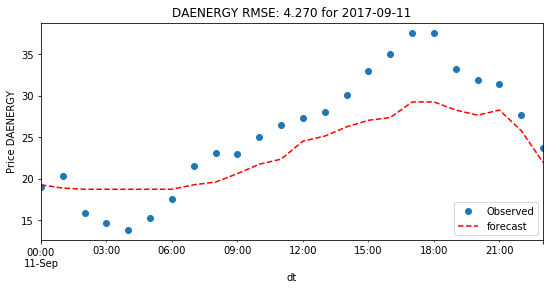

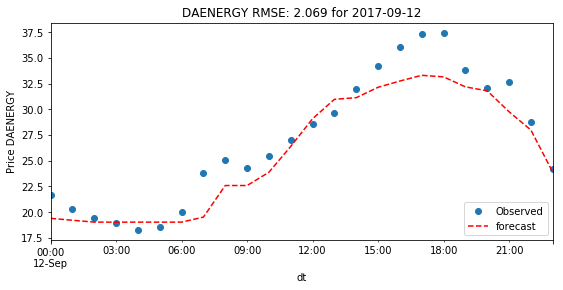

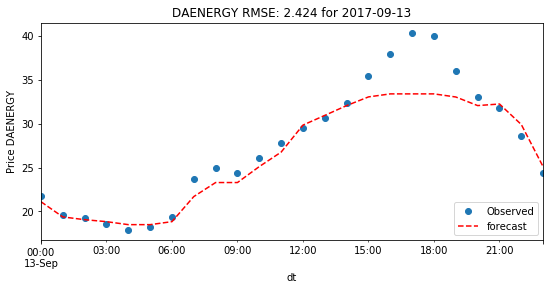

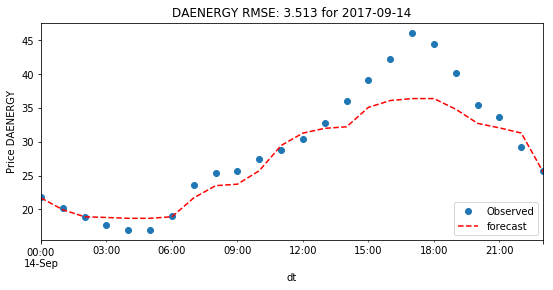

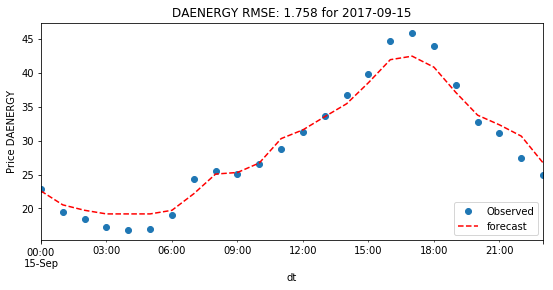

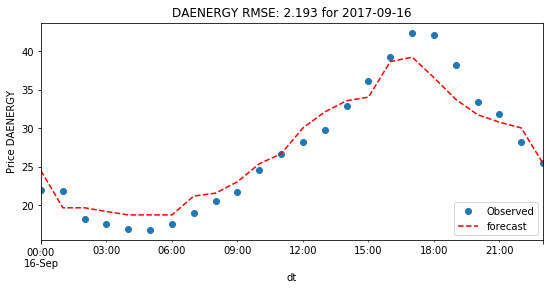

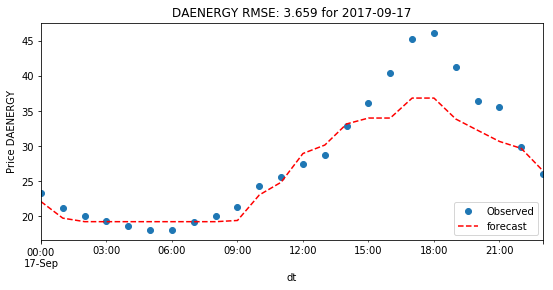

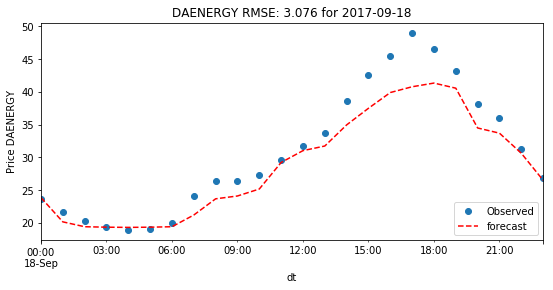

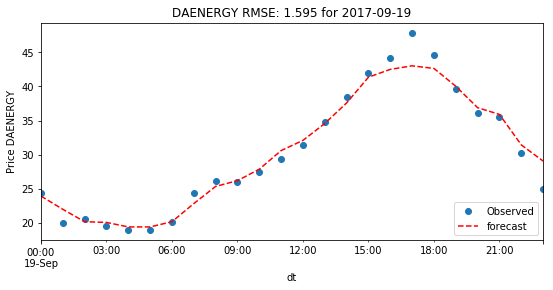

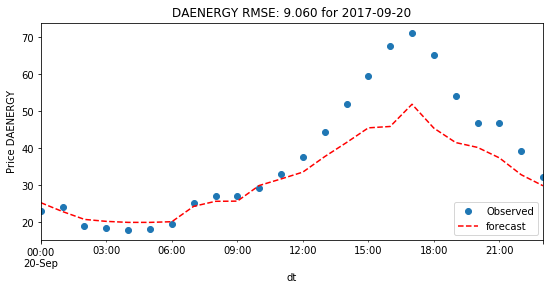

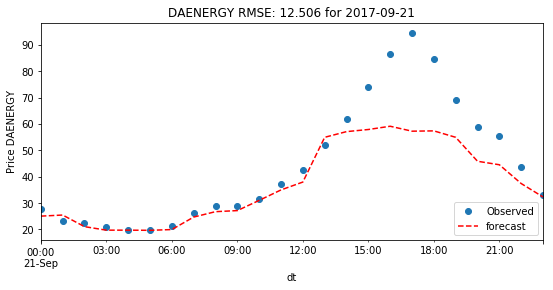

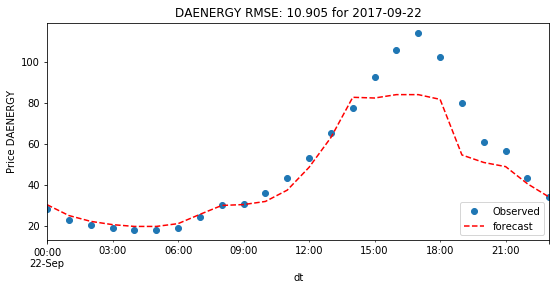

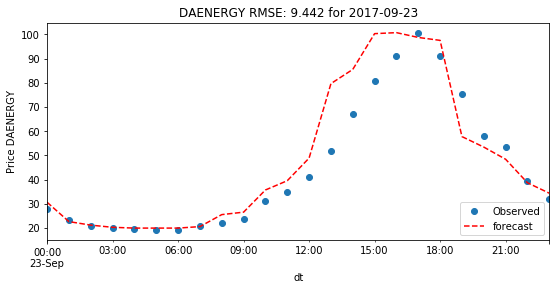

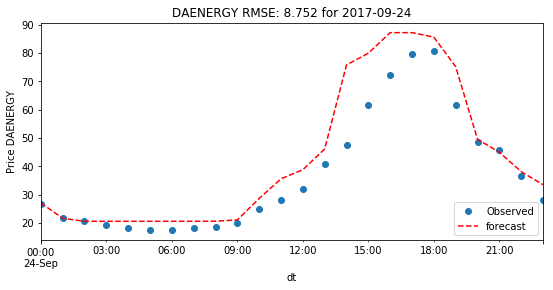

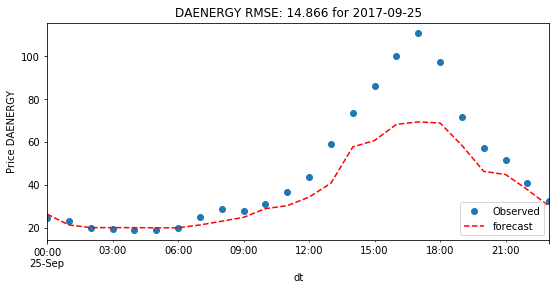

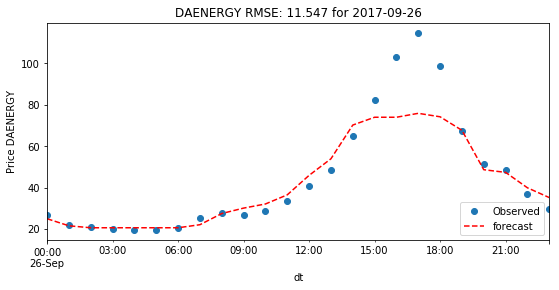

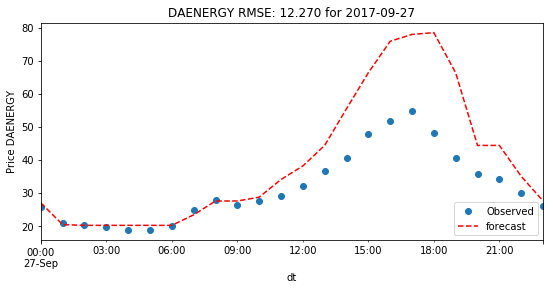

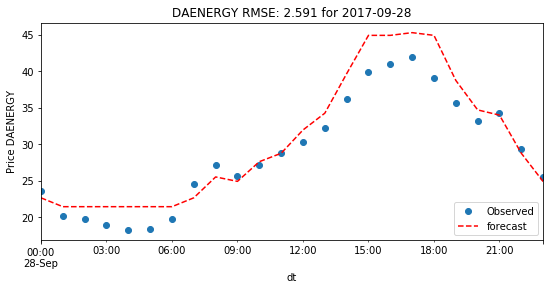

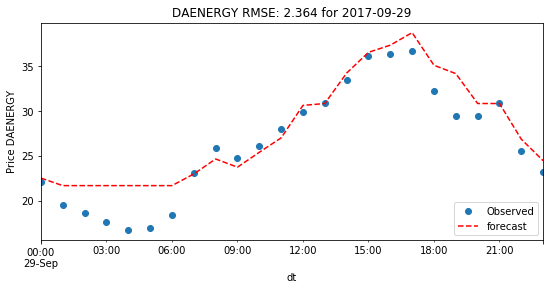

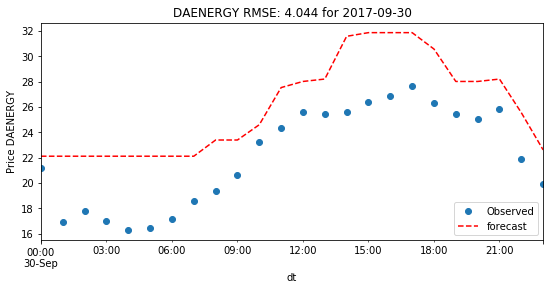

In [62]:
rmses = []
for dt in create_date_range('2017-09-01', '2017-09-30'):
    print('Working for date {}'.format(dt))
    res, rmse = train_and_predict(df,dt)
    rmses.append(rmse)



Mean RMSE for september: 4.801943825877179


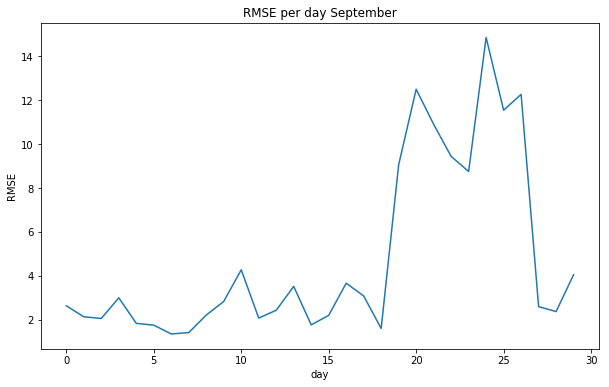

In [63]:
plt.figure(figsize = (10,6))
plt.plot(rmses)
plt.title('RMSE per day September')
plt.xlabel('day')
plt.ylabel('RMSE')
mean_september = np.array(rmses).mean()
print('Mean RMSE for september: {}'.format(mean_september))

In [101]:
def train_model(df,date_predict,model):
    #Prepartinf data to Train
    #print('Preparing data to Train')
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    sk_df = df[:date_limit].copy()
    sk = sk_df.drop(['TRADEDATE', 'RTENERGY'], axis=1)
    sk.hourofday = sk.hourofday.dt.seconds/3600
    sk['daybefore'] = sk.DAENERGY.shift(24)
    sk['weekbefore'] = sk.DAENERGY.shift(24*7)
    #sk['p_36'] = sk.DAENERGY.shift(36)
    sk['p_48'] = sk.DAENERGY.shift(48)
    #sk['p_60'] = sk.DAENERGY.shift(60)
    sk['p_72'] = sk.DAENERGY.shift(72)
    
    sk = sk.dropna()
    y = sk.pop('DAENERGY').values
    X = sk.values
    
    #Training Model
    #print('Training Model')
    model = model.fit(X,y)
    return model

def predict_model(df,date_predict,model):
    #preparing data to Predict
    #print('Preparing data to predict')
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')

    df['weekbefore'] = df.DAENERGY.shift(24*7)
    #df['p_36'] = df.DAENERGY.shift(36)
    df['p_48'] = df.DAENERGY.shift(48)
    #df['p_60'] = df.DAENERGY.shift(60)
    df['p_72'] = df.DAENERGY.shift(72)
    input_p = df[date_limit:date_predict].copy()
    input_p['daybefore'] = input_p.DAENERGY.shift(24)

    input_p = input_p.drop(['DAENERGY','TRADEDATE', 'RTENERGY'], axis=1)
    input_p.hourofday = input_p.hourofday.dt.seconds/3600
    input_p = input_p.dropna()
    
    results = df[date_predict].copy()
    pred_ada = model.predict(input_p.values)
    results['forecast'] = pred_ada
    RMSE = get_rmse(df[date_predict]['DAENERGY'], pred_ada)
    print('RMSE for Model: ', RMSE)
    #preparing to plot
    #print('Ploting results')
    fig, ax = plt.subplots(figsize=(9,4))
    npre = 24
    ax.set(title='DAENERGY '+ 'RMSE: {:.3f} for {}'.format(RMSE, date_predict), xlabel='Date', ylabel='Price DAENERGY')

    # Plot data points
    df.loc[date_predict, 'DAENERGY'].plot(ax=ax, style='o', label='Observed')

    # Plot predictions
    results.forecast.plot(ax=ax, style='r--', label='forecast')
    #ci = predict_ci.loc[date_predict]
    #ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
    legend = ax.legend(loc='lower right')
    
    

    return results, RMSE, input_p.columns

RMSE for Model:  4.5708879315


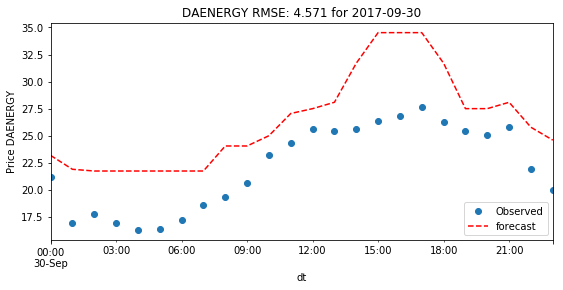

In [96]:
date_predict = '2017-09-30'
model = AdaBoostRegressor(random_state=10)
model = train_model(df,date_predict,model)
res,rmse,cols = predict_model(df,date_predict,model)

Working for date 2017-09-01
RMSE for Model:  2.31091326783
Working for date 2017-09-02
RMSE for Model:  2.1718727299
Working for date 2017-09-03
RMSE for Model:  2.28644343883
Working for date 2017-09-04
RMSE for Model:  3.23208152969
Working for date 2017-09-05
RMSE for Model:  1.40057058267
Working for date 2017-09-06
RMSE for Model:  1.70023369779
Working for date 2017-09-07
RMSE for Model:  1.13769352579
Working for date 2017-09-08
RMSE for Model:  1.21169317407
Working for date 2017-09-09
RMSE for Model:  2.12865312509
Working for date 2017-09-10
RMSE for Model:  2.57816653009
Working for date 2017-09-11
RMSE for Model:  4.24904585989
Working for date 2017-09-12
RMSE for Model:  2.18769214555
Working for date 2017-09-13
RMSE for Model:  2.57798609143
Working for date 2017-09-14
RMSE for Model:  3.46600123084
Working for date 2017-09-15
RMSE for Model:  1.57170383611
Working for date 2017-09-16
RMSE for Model:  2.13970339345
Working for date 2017-09-17
RMSE for Model:  3.9121919477

/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for Model:  8.89581429838
Working for date 2017-09-23


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for Model:  8.59269534164
Working for date 2017-09-24


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for Model:  9.07463393877
Working for date 2017-09-25


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for Model:  13.9544480772
Working for date 2017-09-26


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for Model:  9.12103690517
Working for date 2017-09-27


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for Model:  17.5255348312
Working for date 2017-09-28


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for Model:  2.72645191818
Working for date 2017-09-29


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for Model:  2.43000358593
Working for date 2017-09-30


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


RMSE for Model:  4.08960615288


/Users/david/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


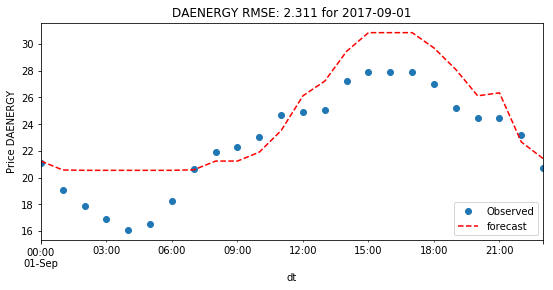

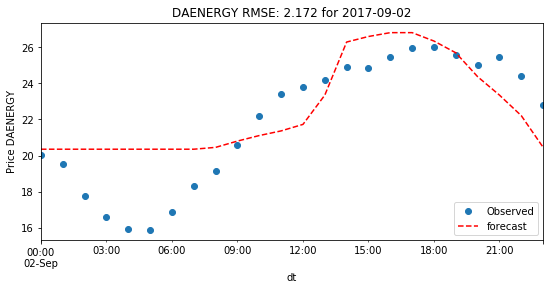

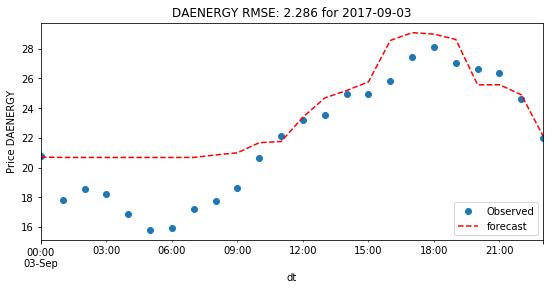

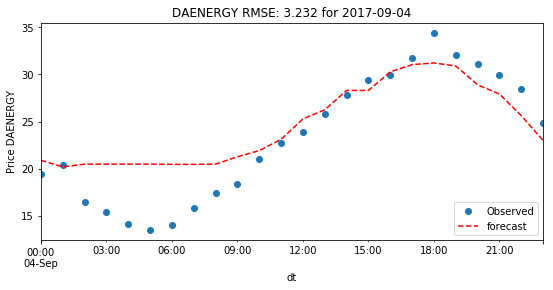

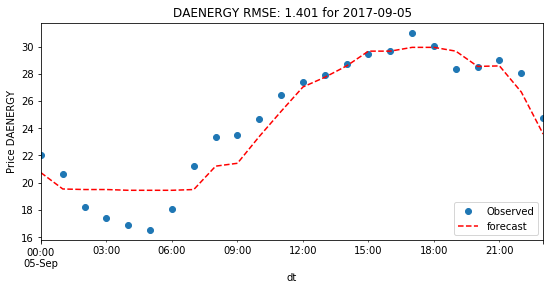

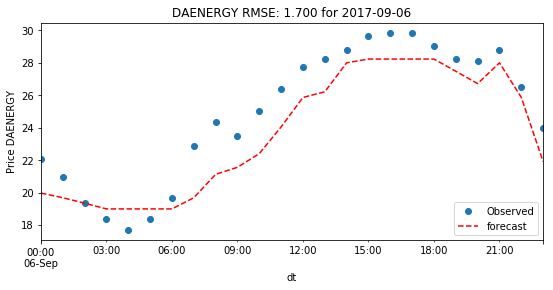

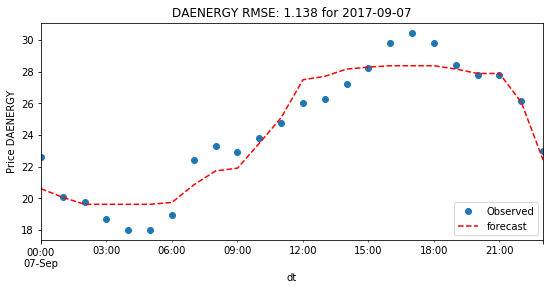

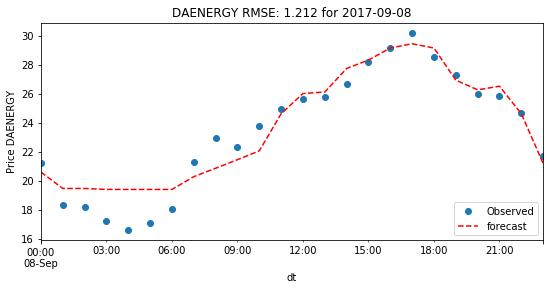

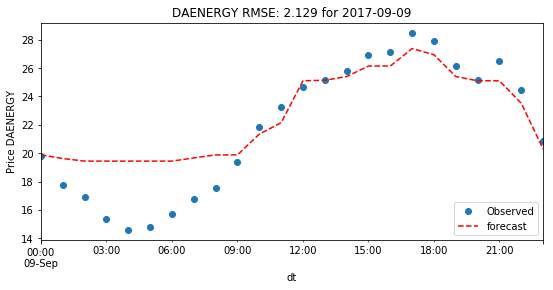

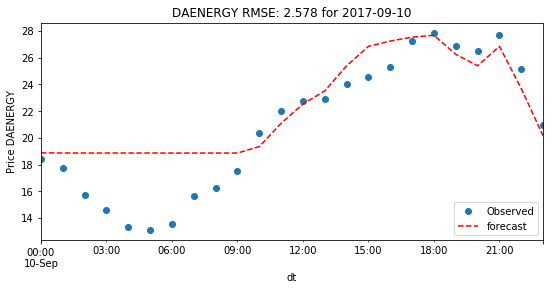

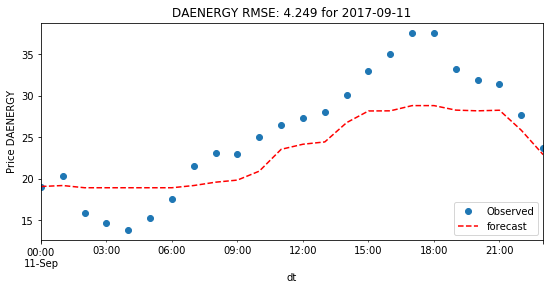

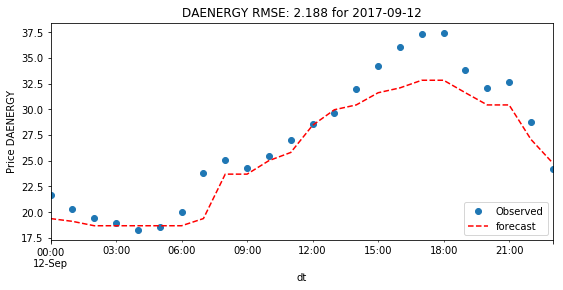

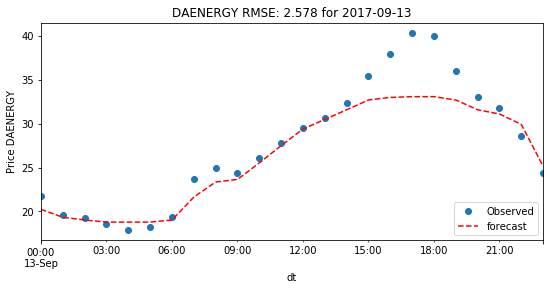

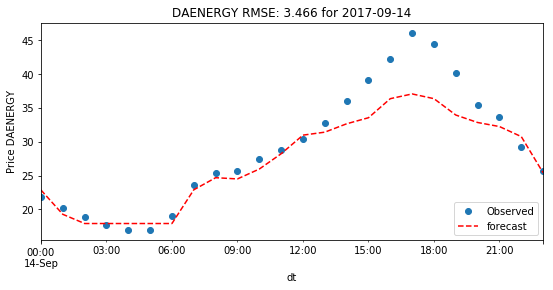

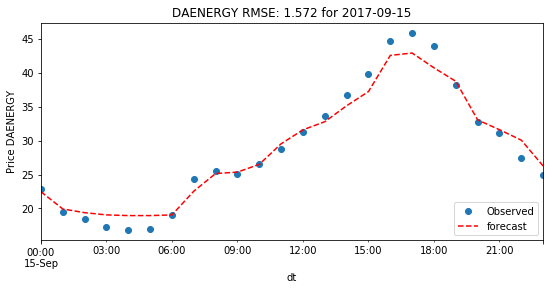

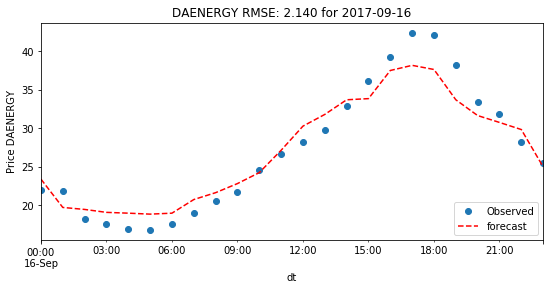

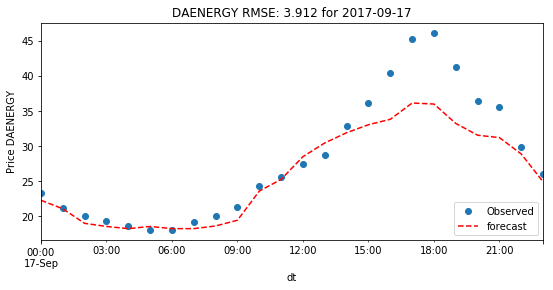

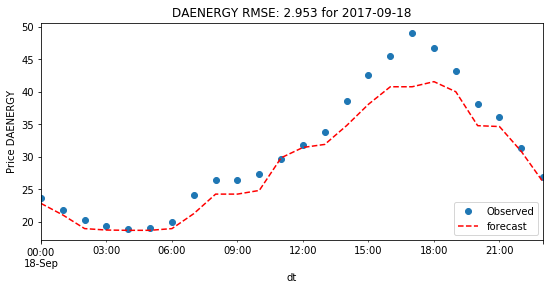

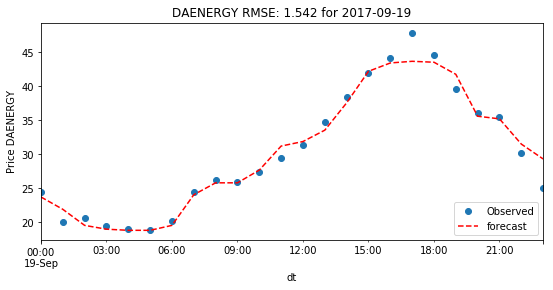

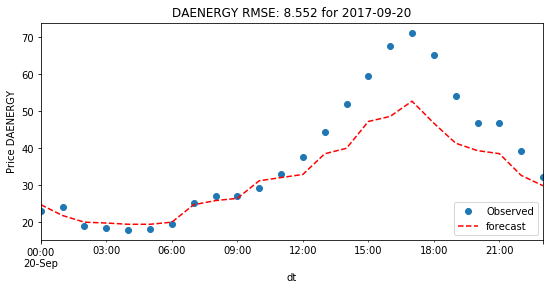

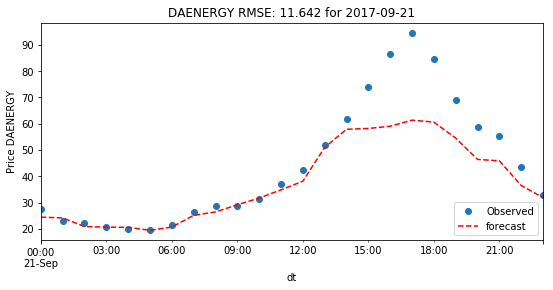

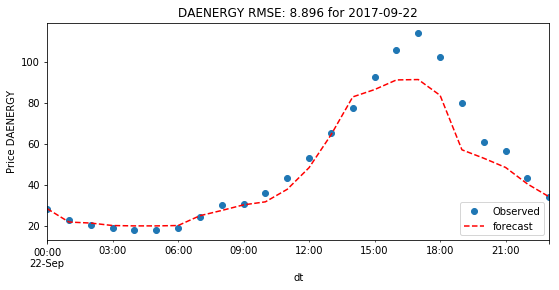

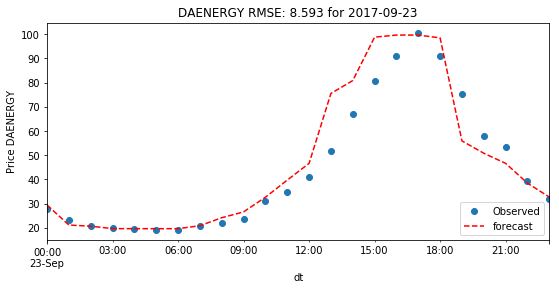

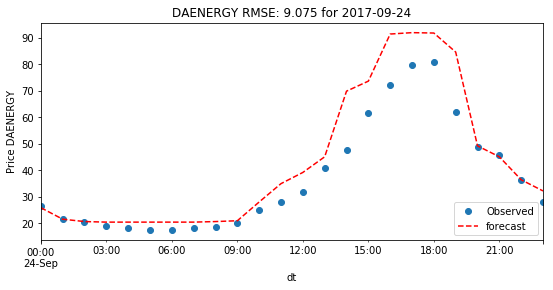

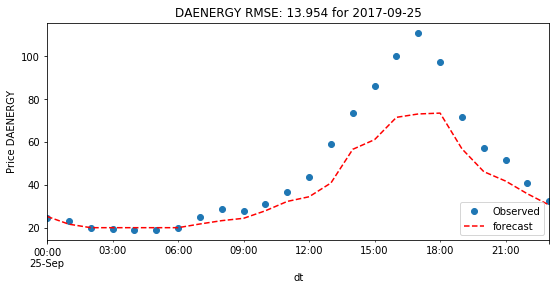

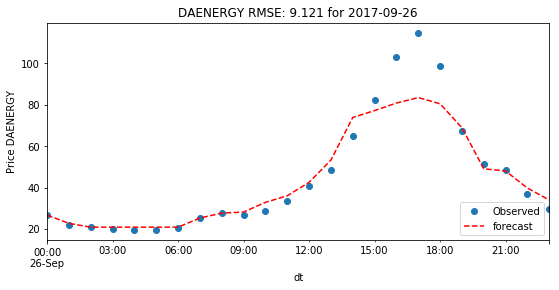

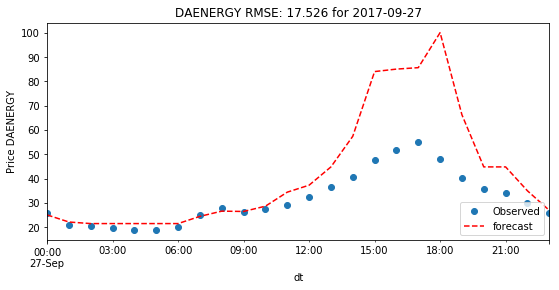

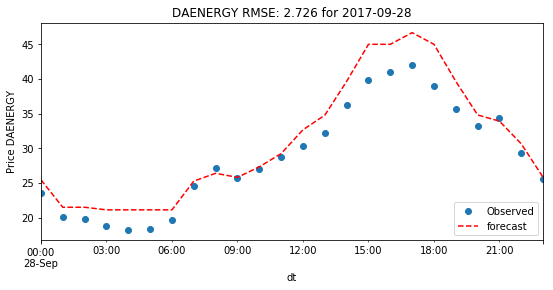

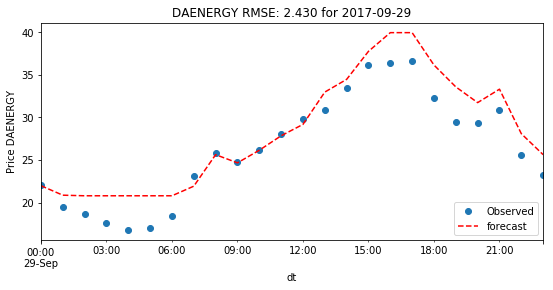

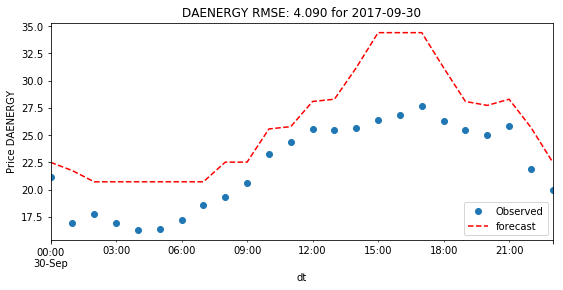

In [107]:
rmses = []
for dt in create_date_range('2017-09-01', '2017-09-30'):
    print('Working for date {}'.format(dt))
    model = AdaBoostRegressor(random_state=10)
    model = train_model(df,dt,model)
    res, rmse,cols = predict_model(df,dt,model)
    rmses.append(rmse)

Mean RMSE for september: 4.7120750065659935


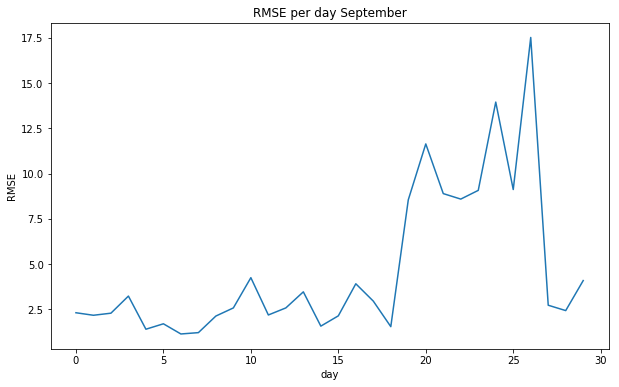

In [108]:
plt.figure(figsize = (10,6))
plt.plot(rmses)
plt.title('RMSE per day September')
plt.xlabel('day')
plt.ylabel('RMSE')
mean_september = np.array(rmses).mean()
print('Mean RMSE for september: {}'.format(mean_september))

In [86]:
print(cols[np.argsort(model.feature_importances_)[::-1]])

Index(['daybefore', 'LOAD', 'OUTAGE', 'weekbefore', 'KCGX', 'KEWR', 'KMKE',
       'KANJ', 'KDOV', 'KORF',
       ...
       'KJAN', 'KJCT', 'KLAN', 'KLBB', 'KLFK', 'KLIT', 'KLNS', 'KLYH', 'KMCI',
       'HOUROFWEEK'],
      dtype='object', name='REGION', length=142)


In [113]:
decomposition.seasonal

dt
2017-07-05 01:00:00    -7.671037
2017-07-05 02:00:00    -9.156224
2017-07-05 03:00:00   -10.033016
2017-07-05 04:00:00   -10.632180
2017-07-05 05:00:00   -10.713519
2017-07-05 06:00:00    -9.793085
2017-07-05 07:00:00    -7.022027
2017-07-05 08:00:00    -5.230840
2017-07-05 09:00:00    -4.438580
2017-07-05 10:00:00    -2.687291
2017-07-05 11:00:00    -0.702034
2017-07-05 12:00:00     1.274257
2017-07-05 13:00:00     3.449290
2017-07-05 14:00:00     6.652663
2017-07-05 15:00:00    10.182976
2017-07-05 16:00:00    12.907453
2017-07-05 17:00:00    15.629135
2017-07-05 18:00:00    14.511391
2017-07-05 19:00:00     9.892766
2017-07-05 20:00:00     7.200259
2017-07-05 21:00:00     4.406023
2017-07-05 22:00:00     0.904363
2017-07-05 23:00:00    -3.211652
2017-07-06 00:00:00    -5.719091
2017-07-06 01:00:00    -7.671037
2017-07-06 02:00:00    -9.156224
2017-07-06 03:00:00   -10.033016
2017-07-06 04:00:00   -10.632180
2017-07-06 05:00:00   -10.713519
2017-07-06 06:00:00    -9.793085
       